# model_training Marketplace en Línea

En este notebook se lleva a cabo el entreno del modelo predictivo para que logre cumplir su funcion de predecir si un artículo listado en el marketplace es nuevo o usado.

#### Importamos las librerias necesarias 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

#### Añadimos el directorio raíz al sys.path para facilitar importaciones

In [3]:
import os

notebook_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
os.chdir(root_dir)

print("Directorio de trabajo actual después del cambio:", os.getcwd())

Directorio de trabajo actual después del cambio: c:\Users\camilo\taller1\model_training


#### Cargamos los datos 

In [4]:
df_cleaned = pd.read_csv('Data\dataset_cleaned.csv', delimiter=',')

#### Definir características (X) y variable objetivo (y)

Usar todas las columnas menos 'condition'

In [5]:
X = df_cleaned.drop(columns=['condition'])  
y = df_cleaned['condition'] 

Codificamos la variable objetivo usando LabelEncoder

In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y) 

#### Función para extraer información de la columna 'shipping', Extraemos los valores relevantes del diccionario a nuevas columnas


In [7]:
df_cleaned['shipping_dict'] = df_cleaned['shipping'].apply(lambda x: eval(x)) 

df_cleaned['free_shipping'] = df_cleaned['shipping_dict'].apply(lambda x: x.get('free_shipping', False))
df_cleaned['local_pick_up'] = df_cleaned['shipping_dict'].apply(lambda x: x.get('local_pick_up', False))

print(df_cleaned[['shipping', 'free_shipping', 'local_pick_up']])

                                                shipping  free_shipping  \
0      {'local_pick_up': True, 'methods': [], 'tags':...          False   
1      {'local_pick_up': True, 'methods': [], 'tags':...          False   
2      {'local_pick_up': True, 'methods': [], 'tags':...          False   
3      {'local_pick_up': True, 'methods': [], 'tags':...          False   
4      {'local_pick_up': True, 'methods': [], 'tags':...          False   
...                                                  ...            ...   
99995  {'local_pick_up': True, 'methods': [], 'tags':...          False   
99996  {'local_pick_up': False, 'methods': [], 'tags'...          False   
99997  {'local_pick_up': False, 'methods': [], 'tags'...          False   
99998  {'local_pick_up': True, 'methods': [], 'tags':...          False   
99999  {'local_pick_up': True, 'methods': [], 'tags':...          False   

       local_pick_up  
0               True  
1               True  
2               True  
3      

#### Codificamos las variables categoricas 

In [8]:
categorical_columns = X.select_dtypes(include=['object']).columns

threshold = 100  
columns_for_one_hot = [col for col in categorical_columns if X[col].nunique() <= threshold]
columns_for_label_encoding = [col for col in categorical_columns if X[col].nunique() > threshold]

X = pd.get_dummies(X, columns=columns_for_one_hot, drop_first=True)

label_encoder = LabelEncoder()
for col in columns_for_label_encoding:
    X[col] = label_encoder.fit_transform(X[col].astype(str))  

print(X.head())

   warranty  base_price  variations  location   price  attributes  \
0        64        80.0           0      1352    80.0           0   
1      6502      2650.0           0      1352  2650.0           0   
2        64        60.0           0      1352    60.0           0   
3        64       580.0           0      1352   580.0           0   
4      6074        30.0           0      1352    30.0           0   

   listing_source  category_id  pictures  original_price  ...  \
0             NaN         1778     71128             0.0  ...   
1             NaN          105     49556             0.0  ...   
2             NaN         1458     29522             0.0  ...   
3             NaN         9964     46086             0.0  ...   
4             NaN         6772     34385             0.0  ...   

   shipping_{'local_pick_up': True, 'methods': [], 'tags': [], 'free_shipping': False, 'mode': 'me1', 'dimensions': None}  \
0                                              False                 

#### Dividimos los datos en conjunto de entrenamiento y prueba (70% entrenamiento, 30% prueba)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Probamos el modelo 

Usaremos los diguientes modelos: 

1. Árbol de Decisión: pues es un buen punto de partida para problemas de clasificación, fácil de interpretar pero puede sobreajustarse.
2. Random Forest: Extiende el árbol de decisión para mejorar la precisión y reducir el sobreajuste mediante un conjunto de árboles.
te separadas.

Las metricas que se usan son: 

1. Accuracy: Proporción de predicciones correctas.
2. Precision: Cantidad de verdaderos positivos sobre todas las predicciones positivas.
3. Recall: Cantidad de verdaderos positivos sobre todos los casos positivos reales.  
4. F1-Score: Media armónica entre Precision y Recall. 
5. ROC-AUC: para medir la capacidad del modelo para discriminar entre las clases.

In [10]:
model_results = {}

# 1. Árbol de Decisión
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
model_results['Decision Tree'] = {
    'Accuracy': accuracy_score(y_test, y_pred_dt),
    'Precision': precision_score(y_test, y_pred_dt),
    'Recall': recall_score(y_test, y_pred_dt),
    'F1-Score': f1_score(y_test, y_pred_dt),
    'ROC-AUC': roc_auc_score(y_test, dt_model.predict_proba(X_test)[:, 1])
}

# 2. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
model_results['Random Forest'] = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'ROC-AUC': roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
}

for model, metrics in model_results.items():
    print(f"Modelo: {model}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("\n")

Modelo: Decision Tree
Accuracy: 0.7802333333333333
Precision: 0.7598077888546224
Recall: 0.7655730596907068
F1-Score: 0.7626795291746158
ROC-AUC: 0.7791793030169907


Modelo: Random Forest
Accuracy: 0.8384666666666667
Precision: 0.7932811480756686
Recall: 0.8788119670472612
F1-Score: 0.8338590235874932
ROC-AUC: 0.9149062317778697




### Modelo: **Decision Tree**
- **Accuracy (Precisión)**: 0.78 (~78.02%)
  - Esto indica que el 78.02% de las predicciones del modelo son correctas. 

- **Precision (Precisión)**: 0.76 (~76.00%)
  - Significa que de todas las instancias que el modelo predijo como positivas, el 76% son realmente positivas.

- **Recall (Sensibilidad)**: 0.77 (~76.56%)
  - El modelo identificó correctamente el 76.56% de todas las instancias positivas. Esto es un buen indicador de que el modelo está capturando la mayoría de los casos positivos.

- **F1-Score**: 0.76 (~76.27%)
  - El F1-Score es una métrica que considera tanto la precisión como el recall. Un valor de 0.76 indica un buen equilibrio entre ambas métricas.

- **ROC-AUC**: 0.78 (~78.00%)
  - Un AUC de 0.78 sugiere que el modelo tiene una capacidad razonable para distinguir entre clases positivas y negativas.

### Modelo: **Random Forest**
- **Accuracy (Precisión)**: 0.84 (~84.85%)
  - Esto indica que el 84.85% de las predicciones son correctas, lo que es una mejora notable sobre el modelo de Árbol de Decisión.

- **Precision (Precisión)**: 0.79 (~79.33%)
  - El modelo tiene una precisión del 79.33%, lo que significa que es más preciso que el modelo de Árbol de Decisión en cuanto a sus predicciones positivas.

- **Recall (Sensibilidad)**: 0.88 (~87.88%)
  - Este valor es bastante alto, lo que indica que el modelo de Random Forest captura el 87.88% de los casos positivos, lo que es significativamente mejor que el modelo de Árbol de Decisión.

- **F1-Score**: 0.83 (~83.39%)
  - Un F1-Score de 0.83 sugiere que el modelo está bien equilibrado en términos de precisión y recall, siendo más efectivo que el modelo de Árbol de Decisión.

- **ROC-AUC**: 0.91 (~91.49%)
  - Un AUC de 0.91 indica que el modelo tiene una excelente capacidad para distinguir entre las clases. Este es un buen indicador de que el modelo de Random Forest es mucho más robusto.

### **Conclusiones Generales**
- **Mejora del Modelo**: El modelo de Random Forest tiene un rendimiento superior en todas las métricas en comparación con el Árbol de Decisión. El modelo de Random Forest parece ser la mejor opción para la tarea de clasificación basada en los resultados obtenidos.

#### Guardamos el modelo de random forest

In [11]:
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

#### Cargamos el modelo 

In [12]:
loaded_model = joblib.load('Models/random_forest_model.pkl')

#### Creamos graficas para tener una mejor idea del comportamiento del modelo 

##### Calcular la matriz de confusión

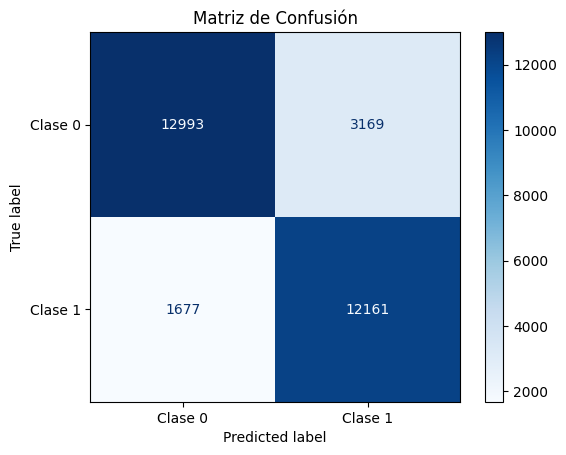

In [13]:
y_pred_loaded_model = loaded_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_loaded_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clase 0', 'Clase 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

##### Tasa de Falsos Positivos 

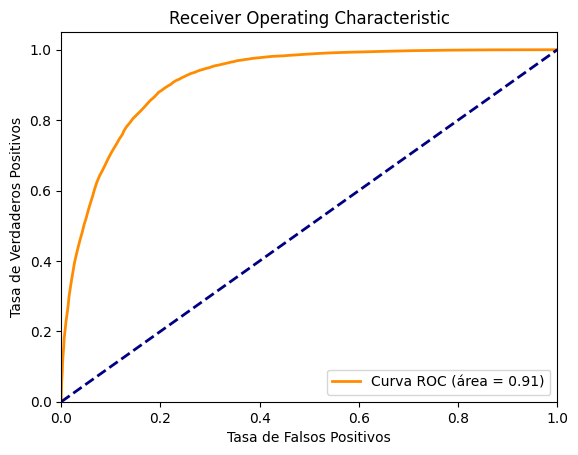

In [14]:
fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

##### Distribucion de Probabilidades de Prediccion 

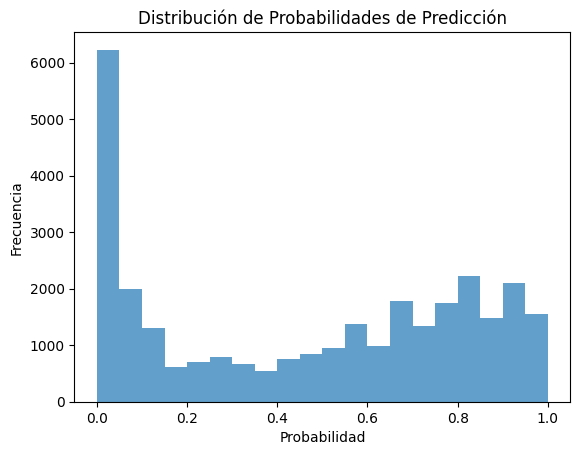

In [15]:
y_pred_proba = loaded_model.predict_proba(X_test)[:, 1]
plt.hist(y_pred_proba, bins=20, alpha=0.7)
plt.title("Distribución de Probabilidades de Predicción")
plt.xlabel("Probabilidad")
plt.ylabel("Frecuencia")
plt.show()
